In [1]:
from __future__ import division
from __future__ import print_function

import os

import matplotlib

import pandas

import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn import tree
import pydotplus 

from sklearn import metrics

import scipy
from scipy import sqrt

import seaborn as sns
sns.set_style("white")

import sys
sys.path.append('../../modules/')
from Processors import *

In [2]:
from DataInfo import *

In [3]:
from helper import *

In [4]:
masses = [260, 270, 280, 300, 320, 400, 500, 550, 600, 700]
backgroundLabels = ['TT', 'WJetsToLNu']

loc = '../../../data_n/'

data = pandas.read_csv(loc + "fullData.csv", low_memory=False)
data.drop([x for x in data.columns if 'Unnamed' in x], axis=1, inplace=True)

In [5]:
removeMctMatch = True

In [6]:
indeces = {}
for mass in masses:
    indeces[str(mass)] = (data['gen_label'] == str(mass))

for background in backgroundLabels:
    indeces[background] = (data['gen_label'] == background)

In [7]:
selection = indeces[str(masses[0])]
for mass in masses[1:]:
    selection |= indeces[str(mass)]
if removeMctMatch: selection &= data['gen_mctMatch']
sigIdx = data[selection].index.tolist()
selection = indeces[backgroundLabels[0]]
for background in backgroundLabels[1:]:
    selection |= indeces[background]
bkgIdx = data[selection].index.tolist()

In [8]:
sig_devIndeces, sig_valIndeces = \
                train_test_split(sigIdx, test_size=0.2, random_state=1337)
bkg_devIndeces, bkg_valIndeces = \
                train_test_split(bkgIdx, test_size=0.2, random_state=1337)

In [9]:
devIndeces = sig_devIndeces + bkg_devIndeces
valIndeces = sig_valIndeces + bkg_valIndeces

In [10]:
devData = data.iloc[sig_devIndeces].copy()
devData = devData.append(data.iloc[bkg_devIndeces].copy(), ignore_index = True)
valData = data.iloc[sig_valIndeces].copy()
valData = valData.append(data.iloc[bkg_valIndeces].copy(), ignore_index = True)

In [11]:
genFeatures      = [x for x in data.columns if 'gen' in x]
regFeatures      = [x for x in data.columns if 'reg' in x]
regBFeatures     = [x for x in data.columns if 'regB' in x and not 'diH' in x]
regTauFeatures   = [x for x in data.columns if 'regTau' in x and not 'diH' in x]
regHHFeatures    = [x for x in data.columns if 'regHH' in x]
hlFeatures       = [x for x in data.columns if 'hl' in x]
phiFeatures      = [x for x in data.columns if 'phi' in x and not x in genFeatures+regFeatures+hlFeatures]
etaFeatures      = [x for x in data.columns if 'eta' in x and not x in genFeatures+regFeatures+hlFeatures]
cardinalFeatures = [x for x in data.columns if ('px' in x or 'py' in x or 'pz' in x) and not x in genFeatures+regFeatures+hlFeatures]
pTFeatures       = [x for x in data.columns if 'pT' in x and not x in genFeatures+regFeatures+hlFeatures]
massFeatures     = [x for x in data.columns if 'mass' in x and not x in genFeatures+regFeatures+hlFeatures]
EFeatures        = [x for x in data.columns if 'E' in x and not x in genFeatures+regFeatures+hlFeatures]
pFeatures        = [x for x in data.columns if '|p|' in x and not x in genFeatures+regFeatures+hlFeatures]
csvFeatures      = [x for x in data.columns if 'csv' in x and not x in genFeatures+regFeatures+hlFeatures]
otherGFeatures   = ['diH_kinFit_prob', 'mT', 'hT', 'sT'] #centrality, upsilon, spherocity, aplanority
otherBFeatures   = [x for x in data.columns if not x in genFeatures+regFeatures+hlFeatures+phiFeatures+etaFeatures+cardinalFeatures+pTFeatures+massFeatures+EFeatures+pFeatures+csvFeatures+otherGFeatures]
print('genFeatures:', len(genFeatures))
print('regFeatures:', len(regFeatures))
print('regBFeatures:', len(regBFeatures))
print('regTauFeatures:', len(regTauFeatures))
print('regHHFeatures:', len(regHHFeatures))
print('hlFeatures:', len(hlFeatures))
print('phiFeatures:', len(phiFeatures))
print('etaFeatures:', len(etaFeatures))
print('cardinalFeatures:', len(cardinalFeatures))
print('pTFeatures:', len(pTFeatures))
print('massFeatures:', len(massFeatures))
print('EFeatures:', len(EFeatures))
print('pFeatures:', len(pFeatures))
print('csvFeatures:', len(csvFeatures))
print('otherGFeatures:', len(otherGFeatures))
print('otherBFeatures:', len(otherBFeatures))

genFeatures: 51
regFeatures: 50
regBFeatures: 16
regTauFeatures: 16
regHHFeatures: 6
hlFeatures: 69
phiFeatures: 8
etaFeatures: 7
cardinalFeatures: 23
pTFeatures: 8
massFeatures: 9
EFeatures: 7
pFeatures: 8
csvFeatures: 2
otherGFeatures: 4
otherBFeatures: 9


In [33]:
classTrainFeatures = [x for x in data.columns if x not in genFeatures]

k = regBFeatures+regTauFeatures+regHHFeatures+phiFeatures+etaFeatures+cardinalFeatures+pTFeatures+massFeatures+EFeatures+pFeatures+csvFeatures+otherGFeatures+otherBFeatures
k = [x for x in k if not x in set([x[x.find('_')+1:] for x in regFeatures])]

trainingFeatures = {'all': [x for x in data.columns if x not in genFeatures],
                    'regressed': regBFeatures+regTauFeatures+regHHFeatures,
                    'regEquivalent': list(set([x[x.find('_')+1:] for x in regFeatures])),
                    'main': phiFeatures+etaFeatures+cardinalFeatures+pTFeatures+massFeatures+EFeatures+pFeatures+csvFeatures+otherGFeatures+otherBFeatures,
                    'try1': etaFeatures+cardinalFeatures+pTFeatures+massFeatures+csvFeatures+otherGFeatures,
                    'try2': regBFeatures+regTauFeatures+regHHFeatures+phiFeatures+etaFeatures+cardinalFeatures+pTFeatures+massFeatures+EFeatures+pFeatures+csvFeatures+otherGFeatures+otherBFeatures,
                    'try3': k,
                    'other': otherBFeatures}


#classTrainFeatures = trainingFeatures['all']
#print("Training on {} features {}". format(len(classTrainFeatures), sorted(classTrainFeatures)))

In [ ]:
def FOMAfterCut(p):
    cutSignal, cutBackground = [], []
    for mass, data, scores in zip(masses, signalTestData, signalScore):
        #NOTE: since this is using only the test data this must be divided by test_size
        cutSignal.append(np.sum(scores > p) / (.2 if mass not in removeFromTrain else 1))
    for data, scores in zip(backgroundTestData, backgroundScore):
        cutBackground.append(np.sum(scores > p) / .2)

    return calculateFOM(cutSignal, cutBackground, range(len(cutSignal)), range(len(cutBackground)))

In [62]:
def analyze(kind):
    loc = 'results_' + kind + '/'
    if kind not in trainingFeatures:
        raise KeyError(kind + ' is not a valid key')
    
    if not os.path.exists('results_' + kind):
        os.makedirs('results_' + kind)
        
    classTrainFeatures = trainingFeatures[kind]

    X_train = data.iloc[devIndeces][classTrainFeatures]
    X_test  = data.iloc[valIndeces][classTrainFeatures]

    y_train = data.iloc[devIndeces]['gen_target']
    y_test  = data.iloc[valIndeces]['gen_target']
    
    scale = len(bkgIdx)/len(sigIdx)

    weights_train = np.ones(len(y_train))
    weights_test = np.ones(len(y_test))

    weights_train[y_train == 1] = scale
    weights_test[y_test == 1] = scale
    
    # fit model on training data
    model = xgb.XGBClassifier(random_state=1337, silent=False,
                              objective='binary:logistic',
                              n_estimators=100, eval_metric='auc',
                              max_depth=4, #for testing porpositos
                              n_jobs=8) #NOTE: number of threads to execute
    model.fit(X_train, y_train, sample_weight=weights_train)

    #plot ROC
    plt.figure(figsize=[8, 8])
    plt.plot(*metrics.roc_curve(y_train, 1-model.predict_proba(X_train)[:,0])[:2],
             label=r'Dev, auc=${:.6f}$'.format(metrics.roc_auc_score(y_train, 1-model.predict_proba(X_train)[:,0])),
             color='b', linestyle='dashed')
    plt.plot(*metrics.roc_curve(y_test, 1-model.predict_proba(X_test)[:,0])[:2], 
             label=r'Val, auc=${:.6f}$'.format(metrics.roc_auc_score(y_test, 1-model.predict_proba(X_test)[:,0])),
             color='b')
    plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
    plt.xlabel('Background acceptance', fontsize=24, color='black')
    plt.ylabel('Signal acceptance', fontsize=24, color='black')
    plt.legend(loc='best', fontsize=16)
    plt.savefig(loc + 'roc.pdf')
    plt.show()
    
    #plot distribution
    params = {'hist' : True, 'kde' : False, 'norm_hist' : True, 'bins' : np.linspace(0, 1, 50)}
    plt.figure(figsize=(16, 8))
    a, b = y_test, 1-model.predict_proba(X_test)[:,0]
    signalThing, backgroundThing = b[a.astype(bool)], b[np.logical_not(a.astype(bool))]
    sns.distplot(backgroundThing, label='Background', **params)
    sns.distplot(signalThing, label='Signal', **params)
    plt.legend(loc='best', fontsize=16)
    plt.xlabel("Class prediction", fontsize=24, color='black')
    plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dp}$", fontsize=24, color='black')
    plt.xlim([0,1])
    plt.yscale('log', nonposy='clip')
    plt.savefig(loc + 'distribution.pdf')
    plt.show()
    
    with open(loc + 'results.txt', 'w') as file:
        print(metrics.roc_auc_score(y_train, 1-model.predict_proba(X_train)[:,0]), file=file)
        print(metrics.roc_auc_score(y_test, 1-model.predict_proba(X_test)[:,0]), file=file)
    
    #FOM
    backgroundScore, signalScore = [], []

    for label in backgroundLabels:
        selection = data.iloc[valIndeces]['gen_label'] == label
        backgroundScore.append(1-model.predict_proba(data.iloc[valIndeces][selection][classTrainFeatures])[:,0])

    for mass in masses:
        selection = data.iloc[valIndeces]['gen_label'] == str(mass)
        signalScore.append(1-model.predict_proba(data.iloc[valIndeces][selection][classTrainFeatures])[:,0])
        print(mass, np.average(1-model.predict_proba(data.iloc[valIndeces][selection][classTrainFeatures])[:,0]))
    
    def FOMAfterCutWorse(p):
        cutSignal, cutBackground = [], []
        for i, scores in enumerate(signalScore):
            #NOTE: since this is using only the test data this must be divided by test_size
            if removeMctMatch:
                normalize = np.sum(data[indeces[str(masses[i])]]['gen_mctMatch'])
            else:
                normalize = signalSkimSize[i]
            cutSignal.append(np.sum(scores > p) / len(scores) * normalize)
        for i, scores in enumerate(backgroundScore):
            cutBackground.append(np.sum(scores > p) / len(scores) * backgroundSkimSize[i])

        return calculateFOM(cutSignal, cutBackground, range(len(cutSignal)), range(len(cutBackground)), min)
    
    x = np.linspace(0,1,501)
    y = []
    for i in x:
        y.append(FOMAfterCutWorse(i))
        if y[-1] == -1:
            y = y[:-1]
            break
    x = x[:len(y)]
    
    plt.xlabel('cut')
    plt.ylabel('FOM')
    plt.title('Worse')
    plt.xlim(0,1)
    plt.plot(x, y)
    plt.savefig(loc + 'FOM_worse.pdf')
    plt.show()
    
    del model

try2 :


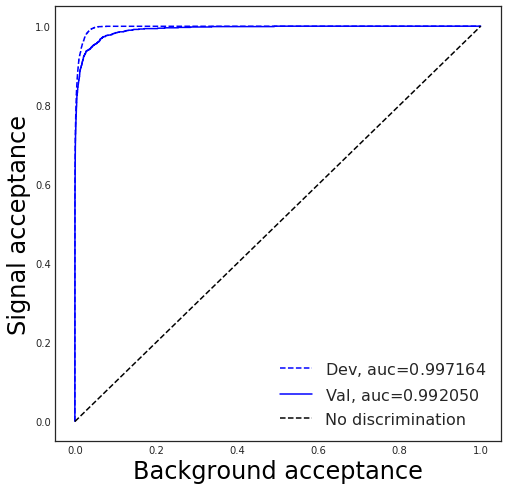

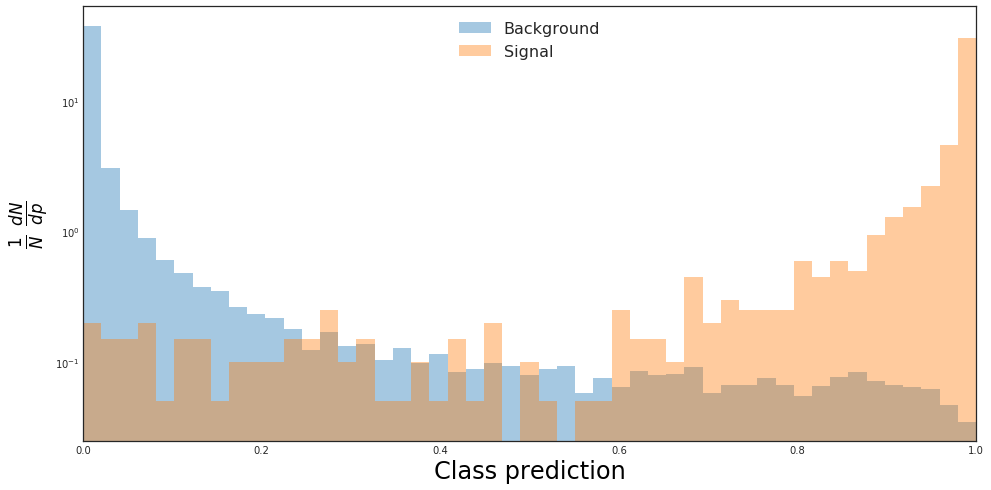

260 0.777734
270 0.671286
280 0.738405
300 0.64477
320 0.737103
400 0.805613
500 0.950081
550 0.960694
600 0.966298
700 0.974912


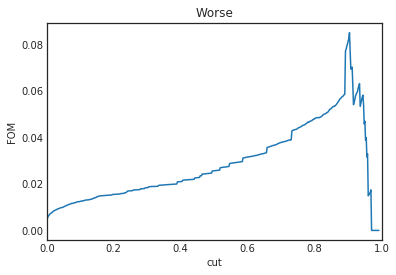

other :


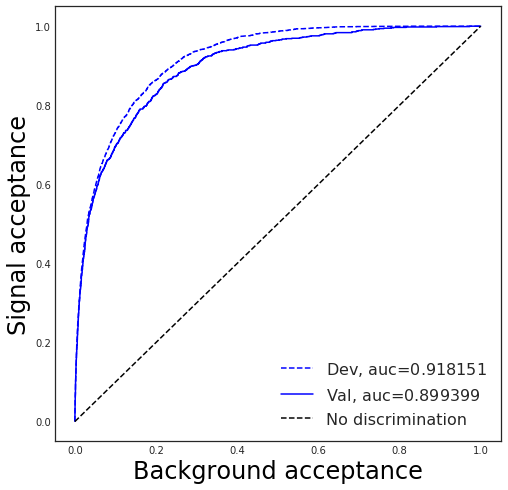

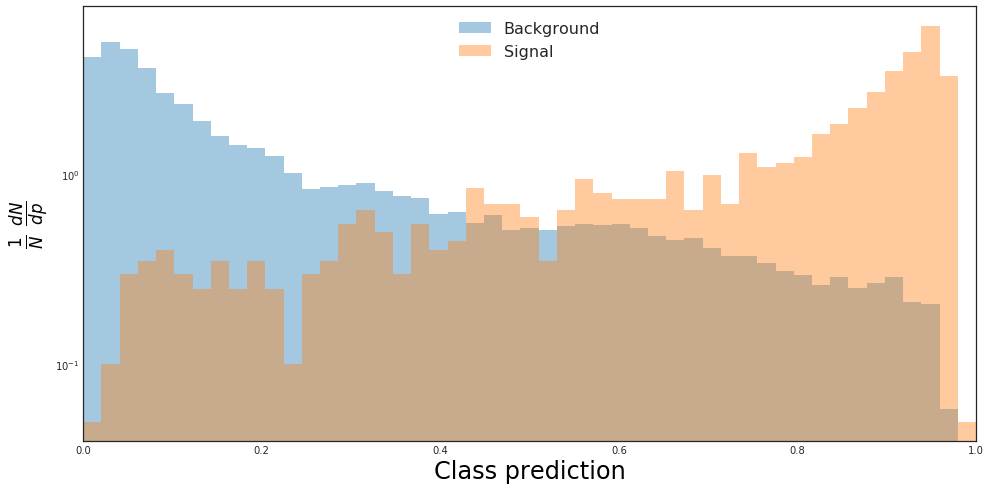

260 0.409605
270 0.420155
280 0.406788
300 0.455472
320 0.490867
400 0.623841
500 0.741099
550 0.782118
600 0.818498
700 0.827578


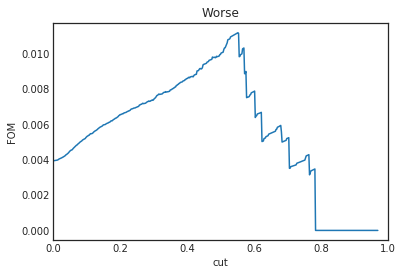

try1 :


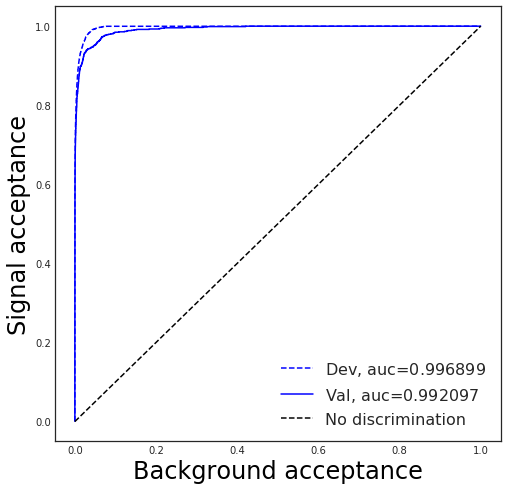

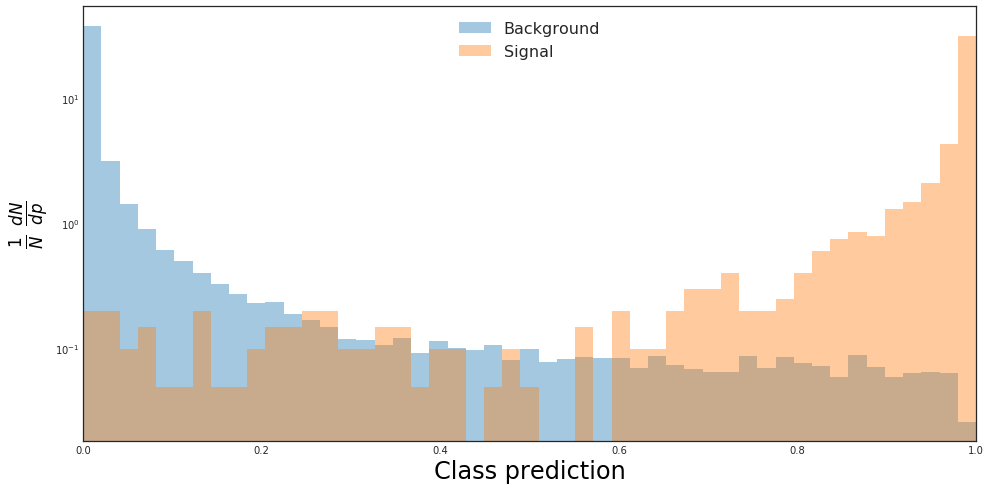

260 0.777937
270 0.682534
280 0.756492
300 0.662579
320 0.752528
400 0.813311
500 0.948774
550 0.962583
600 0.965337
700 0.974275


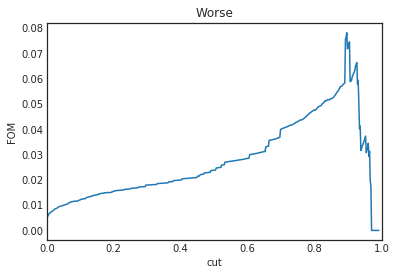

try3 :


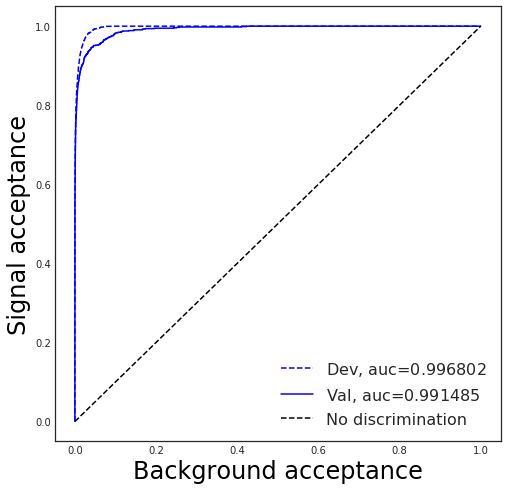

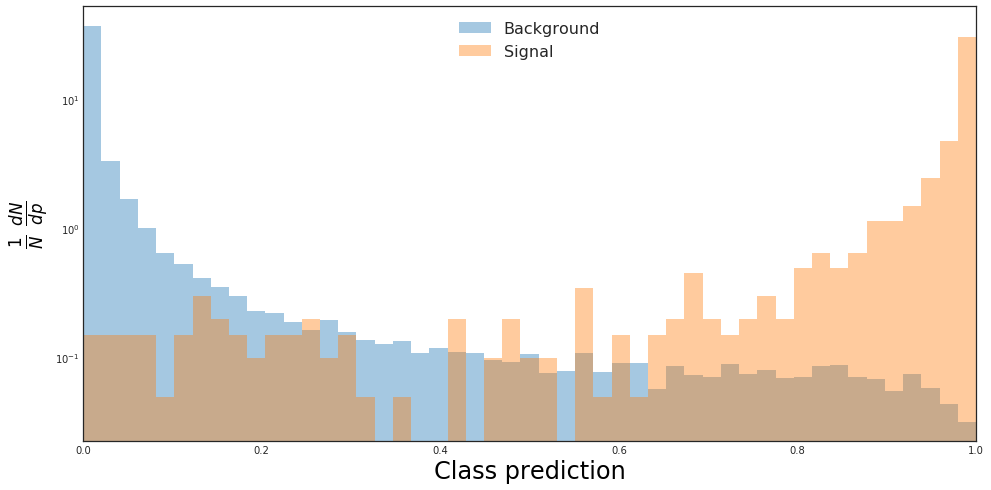

260 0.767219
270 0.67128
280 0.739723
300 0.627768
320 0.728479
400 0.802836
500 0.947499
550 0.959491
600 0.966925
700 0.968392


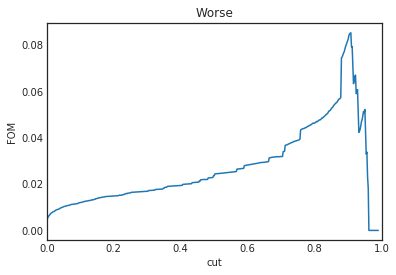

main :


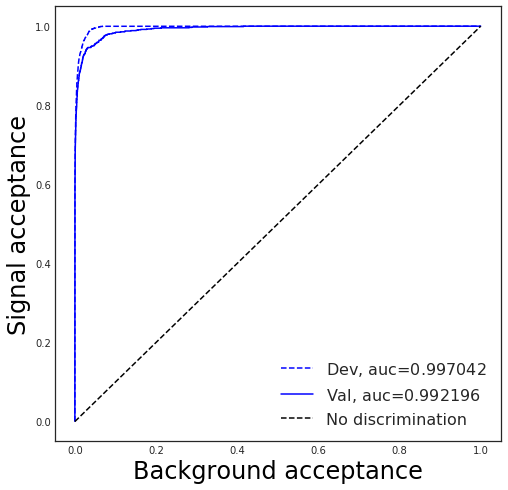

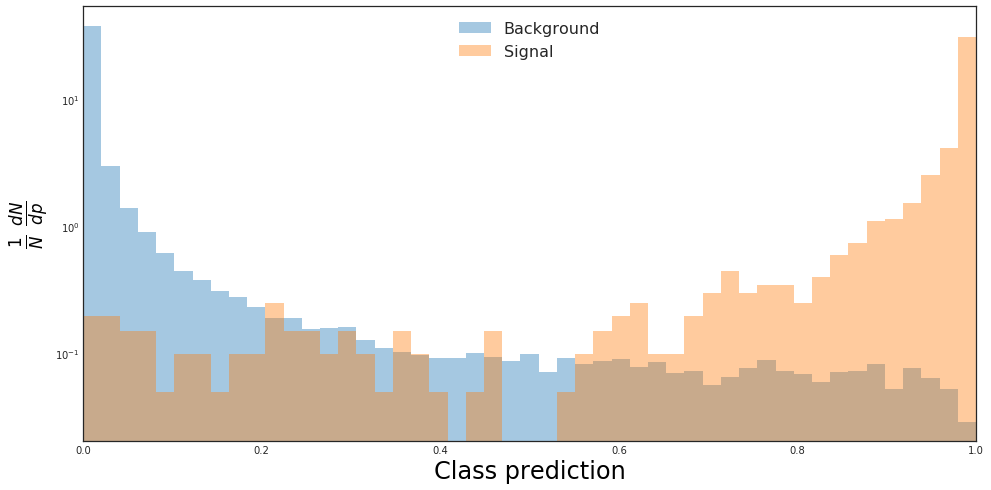

260 0.772509
270 0.681121
280 0.740213
300 0.650558
320 0.748785
400 0.80714
500 0.951431
550 0.962664
600 0.967873
700 0.977002


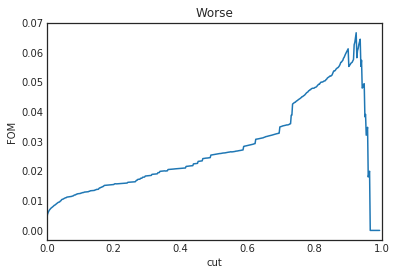

regressed :


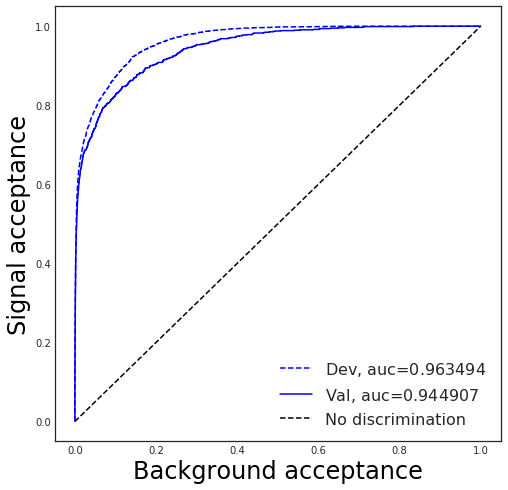

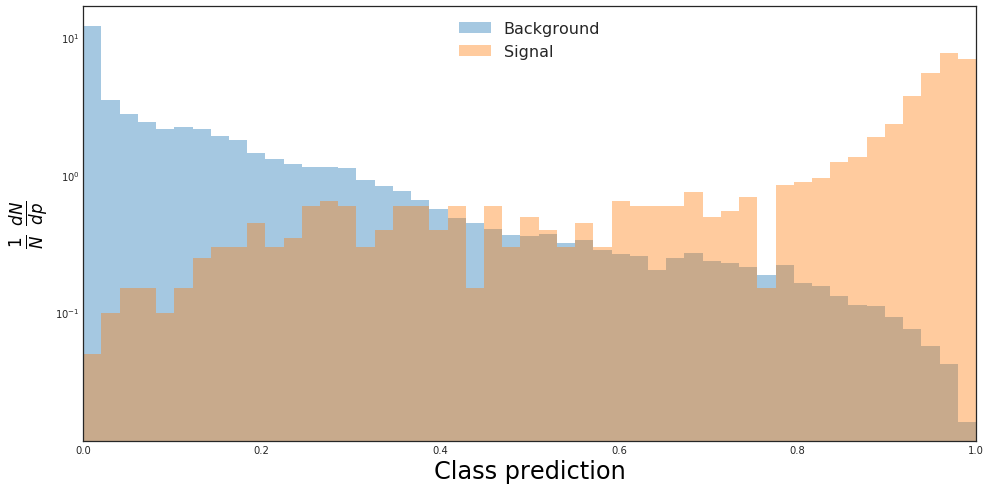

260 0.632254
270 0.559088
280 0.440733
300 0.281423
320 0.270854
400 0.395341
500 0.807946
550 0.903416
600 0.902631
700 0.894337


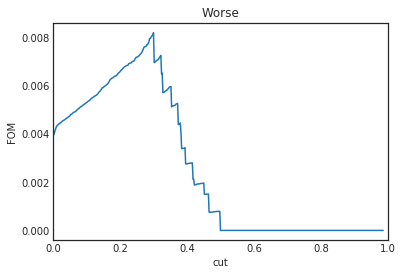

all :


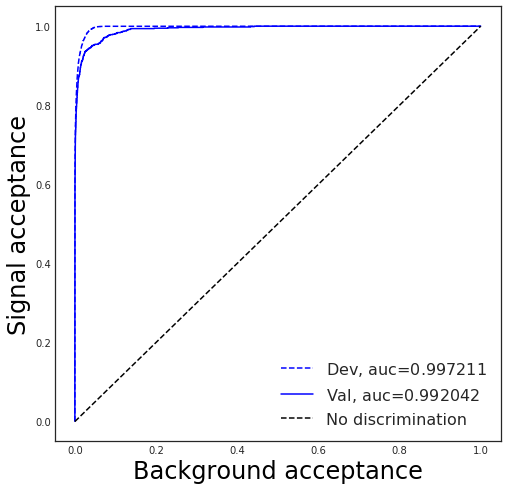

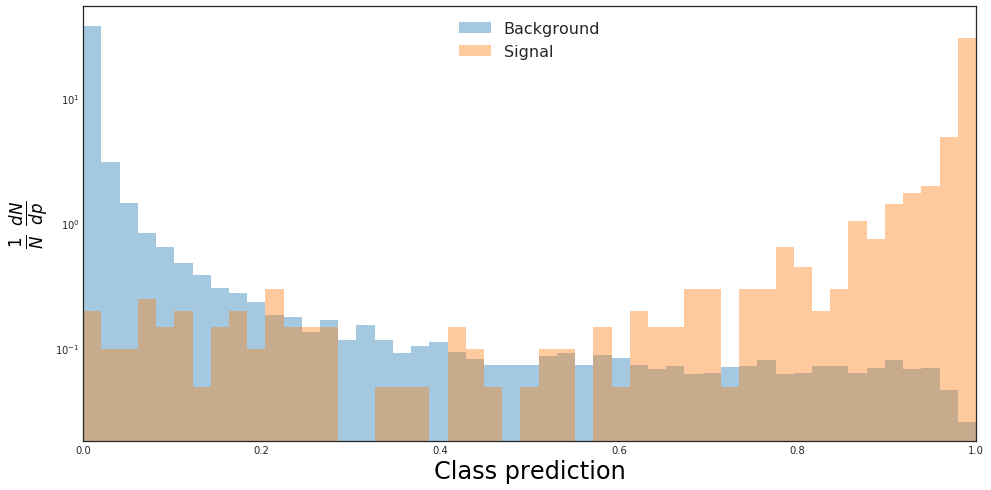

260 0.775348
270 0.675212
280 0.758314
300 0.649102
320 0.742186
400 0.80841
500 0.948462
550 0.960519
600 0.96596
700 0.974503


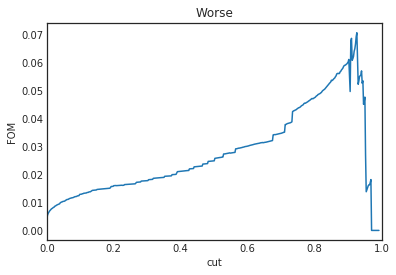

regEquivalent :


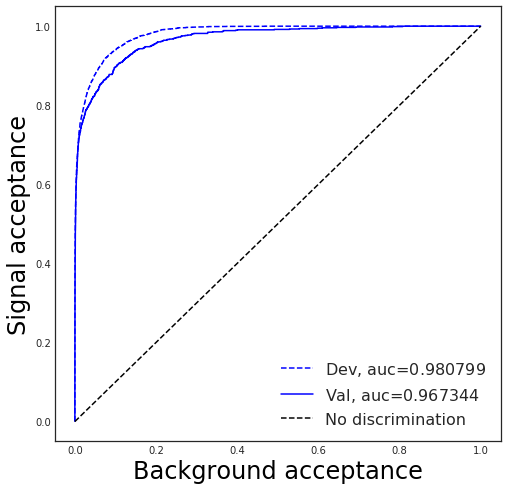

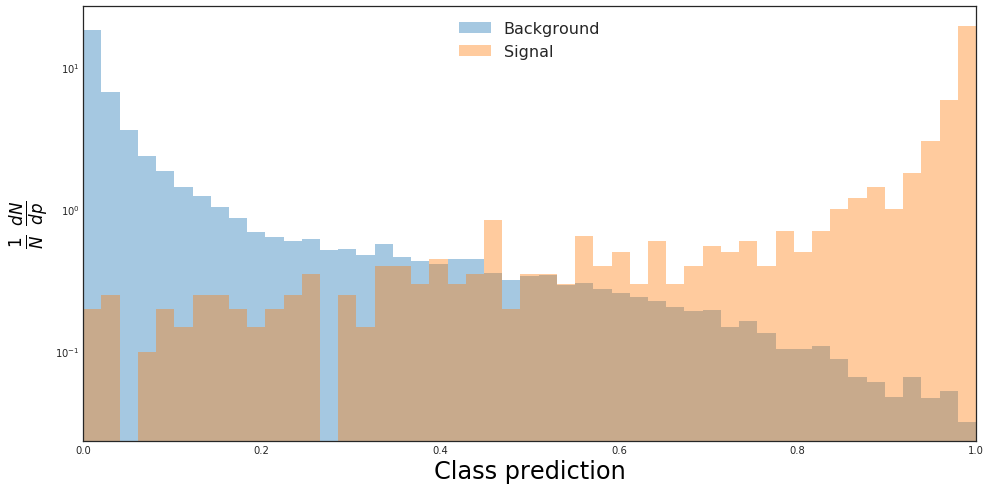

260 0.544678
270 0.506908
280 0.463699
300 0.466277
320 0.478976
400 0.720208
500 0.867023
550 0.911249
600 0.918969
700 0.942307


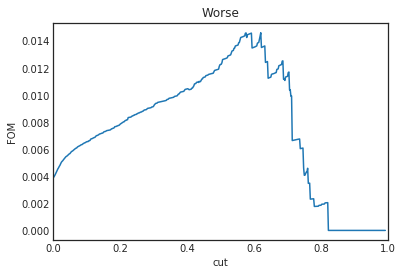

In [63]:
for a in trainingFeatures:
    print(a, ":")
    analyze(a)

In [16]:
X_train = data.iloc[devIndeces][classTrainFeatures]
X_test  = data.iloc[valIndeces][classTrainFeatures]

y_train = data.iloc[devIndeces]['gen_target']
y_test  = data.iloc[valIndeces]['gen_target']

In [17]:
scale = len(bkgIdx)/len(sigIdx)

weights_train = np.ones(len(y_train))
weights_test = np.ones(len(y_test))

weights_train[y_train == 1] = scale
weights_test[y_test == 1] = scale

In [18]:
%%time
# fit model on training data
model = xgb.XGBClassifier(random_state=1337, silent=False,
                          scale_pos_weight=scale,
                          objective='binary:logistic',
                          n_estimators=100, eval_metric='auc',
                          max_depth=4,
                          n_jobs=8) #NOTE: number of threads to execute
model.fit(X_train, y_train)

CPU times: user 9min 16s, sys: 1.42 s, total: 9min 17s
Wall time: 1min 19s


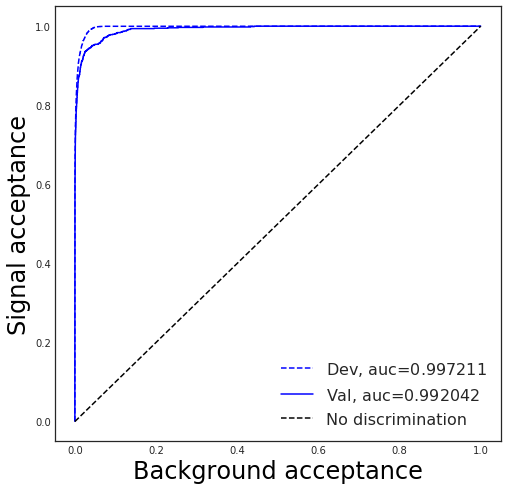

In [19]:
plt.figure(figsize=[8, 8])
plt.plot(*metrics.roc_curve(y_train, 1-model.predict_proba(X_train)[:,0])[:2],
         label=r'Dev, auc=${:.6f}$'.format(metrics.roc_auc_score(y_train, 1-model.predict_proba(X_train)[:,0])),
         color='b', linestyle='dashed')
plt.plot(*metrics.roc_curve(y_test, 1-model.predict_proba(X_test)[:,0])[:2], 
         label=r'Val, auc=${:.6f}$'.format(metrics.roc_auc_score(y_test, 1-model.predict_proba(X_test)[:,0])),
         color='b')
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

In [20]:
print(metrics.roc_auc_score(y_train, 1-model.predict_proba(X_train)[:,0]))
print(metrics.roc_auc_score(y_test, 1-model.predict_proba(X_test)[:,0]))

0.997211093155
0.99204150344


In [21]:
featureInportance = sorted(zip(classTrainFeatures,model.feature_importances_), key= lambda x: x[1], reverse=True)
print(*featureInportance, sep='\n')
print(len(featureInportance))

('h_tt_svFit_mass', 0.11263736)
('diH_kinFit_prob', 0.11057692)
('t_0_pT', 0.058379121)
('h_bb_mass', 0.052197803)
('regHH_diH_mass', 0.05151099)
('diH_kinFit_mass', 0.050824177)
('mT', 0.037774727)
('h_tt_pT', 0.03021978)
('b_1_csv', 0.029532967)
('h_tt_mass', 0.029532967)
('h_bb_pT', 0.023351649)
('b_0_csv', 0.018543957)
('regB_diH_mass', 0.018543957)
('t_1_pT', 0.01510989)
('mPT_pT', 0.014423077)
('hT', 0.012362638)
('b_1_pT', 0.011675824)
('t_0_mass', 0.010989011)
('diH_mass', 0.010302198)
('regB_b_1_px', 0.0089285718)
('regTau_h_tt_|p|', 0.0082417587)
('b_0_mass', 0.0075549451)
('regB_b_1_py', 0.0075549451)
('t_1_|p|', 0.0068681319)
('regB_b_1_|p|', 0.0068681319)
('sT', 0.0061813188)
('hl_dpy_h_tt_mPT', 0.0061813188)
('hl_dpx_h_tt_mPT', 0.0054945056)
('regB_h_bb_mass', 0.0054945056)
('regTau_diH_mass', 0.0054945056)
('regHH_diH_E', 0.0054945056)
('diH_pT', 0.0048076925)
('centrality', 0.0048076925)
('hl_dpz_t_0_t_1', 0.0048076925)
('b_1_phi', 0.0041208793)
('mPT_phi', 0.0041208793